   store_id    city region
0         1  Berlin   DACH
1         2   Paris     FR
   prod_id product   category  price
0      101  Laptop  Computers   1200
1      102   Phone     Phones    800
2      103  Tablet    Tablets    600
   trans_id  store_id  prod_id       date  units_sold
0         1         4      101 2024-03-10           1
1         2         5      107 2024-03-21           2
2         3         3      107 2024-02-20           2
3         4         5      104 2024-01-19           3
4         5         5      105 2024-02-11           2
   trans_id  store_id  prod_id       date  units_sold    city region  \
0         1         4      101 2024-03-10           1  Madrid     ES   
1         2         5      107 2024-03-21           2  London     UK   
2         3         3      107 2024-02-20           2    Rome     IT   
3         4         5      104 2024-01-19           3  London     UK   
4         5         5      105 2024-02-11           2  London     UK   

      product 

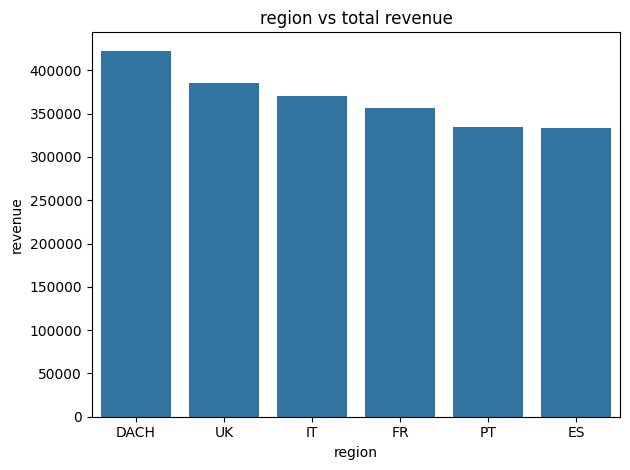

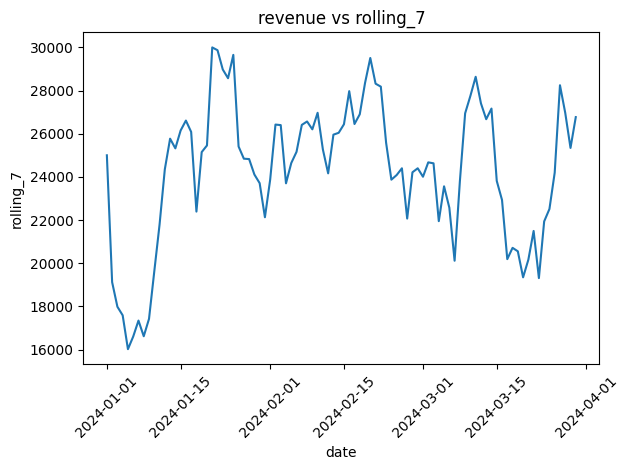

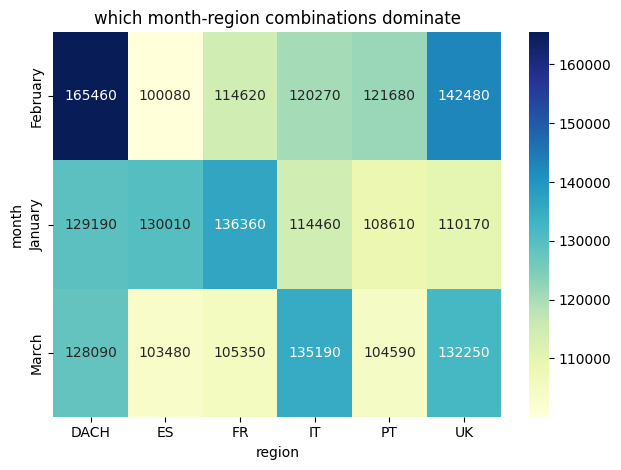

In [26]:
import pandas as pd
import numpy as np

np.random.seed(42)

# --- Stores ---
stores = pd.DataFrame({
    "store_id": range(1, 7),
    "city": ["Berlin","Paris","Rome","Madrid","London","Lisbon"],
    "region": ["DACH","FR","IT","ES","UK","PT"]
})

# --- Products ---
products = pd.DataFrame({
    "prod_id": range(101, 108),
    "product": ["Laptop","Phone","Tablet","Headphones","Monitor","Keyboard","Mouse"],
    "category": ["Computers","Phones","Tablets","Accessories","Monitors","Accessories","Accessories"],
    "price": [1200, 800, 600, 150, 300, 90, 40]
})

# --- Transactions (90 days x ~160 rows) ---
dates = pd.date_range("2024-01-01", periods=90, freq="D")
n_rows = 1600

transactions = pd.DataFrame({
    "trans_id": np.arange(1, n_rows+1),
    "store_id": np.random.choice(stores["store_id"], size=n_rows, replace=True),
    "prod_id":  np.random.choice(products["prod_id"], size=n_rows, replace=True),
    "date":     np.random.choice(dates, size=n_rows, replace=True),
    "units_sold": np.random.randint(1, 6, size=n_rows)  # 1..5 units
})

# Quick peek
print(stores.head(2))
print(products.head(3))
print(transactions.head(5))

part_df = pd.merge(transactions,stores,on="store_id",how="left")
df = pd.merge(part_df,products,on="prod_id",how="left")
print(df.head())

df["revenue"] = df["price"] * df["units_sold"]
df["month"] = df["date"].dt.month_name()
df["week"] = df["date"].dt.isocalendar().week

df.columns = df.columns.str.strip().str.lower().str.replace(" ","_")
df1 = df.dropna()
print(df1.head())

revenue_per_region = df1.groupby("region").agg({"revenue" : "sum"}).sort_values("revenue",ascending=False)
print(revenue_per_region)
avg_price_per_category = df1.groupby("category").agg({"price":"mean"}).sort_values("price",ascending=False)
print(avg_price_per_category)
revenue_per_store = df1.groupby("store_id").agg({"revenue":"sum"}).sort_values("revenue",ascending=False)
revenue_per_store["Rank"] = revenue_per_store.rank(ascending=False)
print(revenue_per_store)
most_sold_category = df1.groupby("category").agg({"units_sold":"sum"}).sort_values("units_sold",ascending=False)
print(most_sold_category)

pivot = pd.pivot_table(
    df1,
    values="revenue",
    index="month",
    columns="region",
    aggfunc="sum",
    fill_value=0
)
print(pivot)

daily_revenue = df1.groupby("date")["revenue"].sum().reset_index()
daily_revenue["rolling_7"] = daily_revenue["revenue"].rolling(window=7, min_periods=1).mean()
print(daily_revenue.head(5))

import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=revenue_per_region, x="region",y="revenue")
plt.title("region vs total revenue")
plt.tight_layout()
plt.show()

sns.lineplot(data=daily_revenue,x="date",y="rolling_7")
plt.xticks(rotation=45)
plt.title("revenue vs rolling_7")
plt.tight_layout()
plt.show()

sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("which month-region combinations dominate")
plt.tight_layout()
plt.show()